# Image classification without the use of machine learning

## Day and Night Image Classifier
---

The day/night image dataset consists of 200 RGB color images in two categories: day and night. There are equal numbers of each example: 100 day images and 100 night images.

We're trying to build a classifier that can accurately label these images as day or night, and that relies on finding distinguishing features between the two types of images!

*Note: All images come from the [AMOS dataset](http://cs.uky.edu/~jacobs/datasets/amos/) (Archive of Many Outdoor Scenes).*


### Import resources

Before we get started on the project code, import the libraries that we'll need.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob #for loading images from a directory
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import os


In [3]:
# Image data directories
image_dir_training = "/content/drive/MyDrive/images/training"
image_dir_test = "/content/drive/MyDrive/images/test/"

## Step 1: Load the datasets and visualize

These first few lines of code will load the training day/night images and store all of them in a variable, `IMAGE_LIST`. This list contains the images and their associated label ("day" or "night"). 

For example, the first image-label pair in `IMAGE_LIST` can be accessed by index: 
``` IMAGE_LIST[0][:]```.


In [4]:
labels = ['day', 'night']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(path)
        for img in os.listdir(path):
            try:
          
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                print(img_arr)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
# Load training data
train = get_data('/content/drive/MyDrive/images/training')
val = get_data('/content/drive/MyDrive/images/test')


Streaming output truncated to the last 5000 lines.
  [113  64  32]]]
[[[13 10 17]
  [13 10 17]
  [13 11 16]
  ...
  [ 8  7  3]
  [16 15 11]
  [ 1  0  0]]

 [[ 9  6 13]
  [10  7 14]
  [13 11 16]
  ...
  [ 5  4  0]
  [11 10  6]
  [12 11  7]]

 [[ 7  4 13]
  [ 7  4 11]
  [11  9 14]
  ...
  [ 1  0  0]
  [ 5  4  0]
  [ 6  5  1]]

 ...

 [[21 10 14]
  [10  0  3]
  [17  6 10]
  ...
  [ 0  1  0]
  [ 2  5  0]
  [ 3  6  0]]

 [[28 17 21]
  [ 8  0  1]
  [15  4  8]
  ...
  [14 15  9]
  [29 32 25]
  [43 46 39]]

 [[26 16 17]
  [22 12 13]
  [29 19 20]
  ...
  [ 7  8  3]
  [ 6  8  3]
  [13 15 10]]]
[[[ 55  37  25]
  [ 55  37  25]
  [ 55  37  25]
  ...
  [ 67  46  29]
  [ 67  46  29]
  [ 67  46  29]]

 [[ 55  37  25]
  [ 55  37  25]
  [ 55  37  25]
  ...
  [ 67  46  29]
  [ 67  46  29]
  [ 67  46  29]]

 [[ 55  37  25]
  [ 55  37  25]
  [ 55  37  25]
  ...
  [ 67  46  29]
  [ 67  46  29]
  [ 67  46  29]]

 ...

 [[182 113  72]
  [149  88  44]
  [128  80  32]
  ...
  [104  54  17]
  [104  54  17]
  [10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Streaming output truncated to the last 5000 lines.
  [110 117  76]]]
[[[125 167 207]
  [124 166 206]
  [124 166 206]
  ...
  [122 164 204]
  [123 165 205]
  [123 165 205]]

 [[125 167 207]
  [124 166 206]
  [124 166 206]
  ...
  [125 167 207]
  [125 167 207]
  [125 167 207]]

 [[125 167 207]
  [124 166 206]
  [124 166 206]
  ...
  [125 167 207]
  [125 167 207]
  [125 167 207]]

 ...

 [[110  98  76]
  [109  97  75]
  [145 133 111]
  ...
  [197 170 143]
  [197 170 143]
  [198 171 144]]

 [[119 104  85]
  [ 74  59  40]
  [ 89  76  57]
  ...
  [200 173 146]
  [200 173 146]
  [200 173 146]]

 [[109  94  75]
  [ 68  53  34]
  [ 84  71  52]
  ...
  [200 173 146]
  [200 173 146]
  [200 173 146]]]
[[[125 182 237]
  [ 92 149 204]
  [ 93 150 205]
  ...
  [105 173 234]
  [105 173 234]
  [105 173 234]]

 [[124 181 236]
  [ 92 149 204]
  [ 92 149 204]
  ...
  [105 173 234]
  [105 173 234]
  [105 173 234]]

 [[123 180 235]
  [ 91 148 203]
  [ 92 149 204]
  ...
  [105 173 234]
  [105 173 234]
  [105 

## Step 2: Preprocess the data input images.

This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and numerical labels.
1. Resizing every image to a standard size
2. Encode the target variables

In [6]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)


## Step 3: Feature Extraction

Let's try to create a feature that represents the brightness in an image. We'll be extracting the **average brightness** using HSV colorspace. Specifically, we'll use the V channel (a measure of brightness), add up the pixel values in the V channel, then divide that sum by the area of the image to get the average Value of the image.


In [7]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## Step 4: Build the classifier

We'll turn our average brightness feature into a classifier that takes in a standardized image and returns a `predicted_label` for that image. This `estimate_label` function should return a value: 0 or 1 (night or day, respectively).

In [8]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [12]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [13]:
history = model.fit(x_train,y_train,epochs = 50 , validation_data = (x_val, y_val))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 21s 2s/step - loss: 0.7079 - accuracy: 0.4750 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 19s 2s/step - loss: 0.6938 - accuracy: 0.5292 - val_loss: 0.6835 - val_accuracy: 0.6187
Epoch 3/50
8/8 [==============================] - 19s 2s/step - loss: 0.6814 - accuracy: 0.6250 - val_loss: 0.6711 - val_accuracy: 0.7563
Epoch 4/50
8/8 [==============================] - 19s 2s/step - loss: 0.6692 - accuracy: 0.6833 - val_loss: 0.6598 - val_accuracy: 0.7688
Epoch 5/50
8/8 [==============================] - 19s 2s/step - loss: 0.6545 - accuracy: 0.7750 - val_loss: 0.6496 - val_accuracy: 0.7437
Epoch 6/50
8/8 [==============================] - 19s 2s/step - loss: 0.6456 - accuracy: 0.7375 - val_loss: 0.6396 - val_accuracy: 0.7250
Epoch 7/50
8/8 [==============================] - 19s 2s/step - loss: 0.6351 - accuracy: 0.7208 - val_loss: 0.6303 - val_accuracy: 0.7063
Epoch 8/50
8/8 [=============================

## Step 5: Evaluate the Classifier and Optimize

Here is where we test your classification algorithm using our test set of data that we set aside at the beginning of the notebook!
Below, we load in the test dataset, standardize it using the `standardize` function you defined above, and then **shuffle** it; this ensures that order will not play a role in testing accuracy.


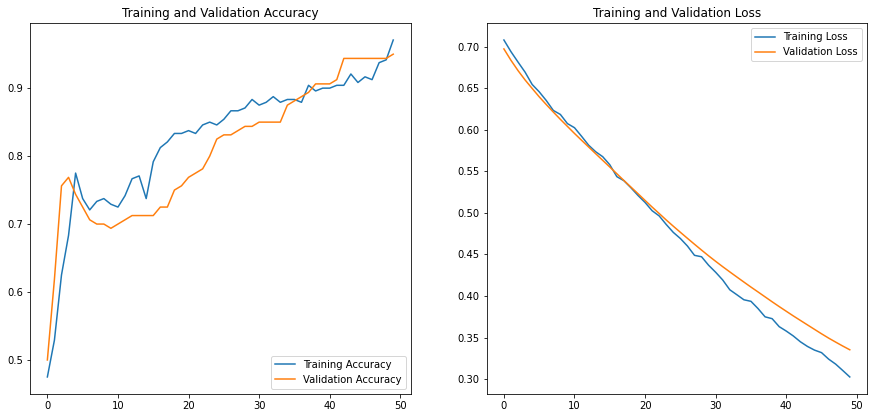

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Tasks:

# Task 1: Execute the above code properly.

# Task 2: Now, implement the image classification with given dataset using machine learning. Also, calculate the accuracy of the model.

# Task 3: Understand and explain what did you analyze. Make a detailed analysis report. Also, cover all of the following questions.
## 1) explain when we should use Machine Learning and when not.
## 2) Compare the accuracy of both the way. Also, explain why you are getting the difference in accuracy.
## 3) Why we use Machine Learning rather than just software development?
## 4) How do you improve the performance of a model and why we need to improve the model performance?


## (Submit the PDF of the report)

# Task 4: Implement the above image classification code without the use of machine learning, but use different dataset.

# Task 5: Implement any other code such as prediction without the use of machine learning.
